# Does Harry Browne's permanent portfolio withstand the test of time?

## Python Imports

In [363]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MultipleLocator
import warnings
import seaborn as sns
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random
warnings.filterwarnings("ignore")

## Python Functions

### bb_data_updater

In [364]:
# This function takes an excel export from Bloomberg and 
# removes all excess data leaving date and close columns

# Imports
import pandas as pd

# Function definition
def bb_data_updater(fund):

    # File name variable
    file = fund + ".xlsx"
    
    # Import data from file as a pandas dataframe
    df = pd.read_excel(file, sheet_name = 'Worksheet', engine='openpyxl')
    
    # Set the column headings from row 5 (which is physically row 6)
    df.columns = df.iloc[5]
    
    # Set the column heading for the index to be "None"
    df.rename_axis(None, axis=1, inplace = True)
    
    # Drop the first 6 rows, 0 - 5
    df.drop(df.index[0:6], inplace=True)
    
    # Set the date column as the index
    df.set_index('Date', inplace = True)
    
    # Drop the volume column
    try:
        df.drop(columns = {'PX_VOLUME'}, inplace = True)
    except KeyError:
        pass
        
    # Rename column
    df.rename(columns = {'PX_LAST':'Close'}, inplace = True)
    
    # Sort by date
    df.sort_values(by=['Date'], inplace = True)
    
    # Export data to excel
    file = fund + "_Clean.xlsx"
    df.to_excel(file, sheet_name='data')
    
    # Output confirmation
    print(f"The last date of data for {fund} is: ")
    print(df[-1:])
    print(f"Bloomberg data conversion complete for {fund} data")
    return print(f"--------------------")

### dp

In [365]:
# Set number of decimal places in pandas

def dp(decimal_places):
    pd.set_option('display.float_format', lambda x: f'%.{decimal_places}f' % x)

dp(3)

### df_info

In [366]:
# The `df_info` function returns some useful information about
# a dataframe, such as the columns, data types, and size.

def df_info(df):
    print('There are ', df.shape[0], ' rows and ', df.shape[1], ' columns')
    print('The columns and data types are:')
    print(df.dtypes)
    print('The first 4 rows are:')
    display(df.head(4))
    print('The last 4 rows are:')
    display(df.tail(4))

### load_data

In [367]:
def load_data(file):
    # Import CSV
    try:
        df = pd.read_csv(file)
    except:
        pass

    # Import excel
    try:
        df = pd.read_excel(file, sheet_name='data', engine='openpyxl')
    except:
        pass
        
    return df

### strategy

In [368]:
def strategy(fund_list, starting_cash, cash_contrib, close_prices_df, rebal_month, rebal_day):

    num_funds = len(fund_list)

    df = close_prices_df.copy()
    df.reset_index(inplace = True)

    # Date to be used for annual rebalance
    target_month = rebal_month
    target_day = rebal_day

    # Create a dataframe with dates from the specific month
    rebal_date = df[df['Date'].dt.month == target_month]

    # Specify the date or the next closest
    rebal_date = rebal_date[rebal_date['Date'].dt.day >= target_day]

    # Group by year and take the first entry for each year
    rebal_dates_by_year = rebal_date.groupby(rebal_date['Date'].dt.year).first().reset_index(drop=True)

    '''
    Column order for the dataframe:
    df[fund + "_BA_Shares"]
    df[fund + "_BA_$_Invested"]
    df[fund + "_BA_Port_%"]
    df['Total_BA_$_Invested']
    df['Contribution']
    df['Rebalance']
    df[fund + "_AA_Shares"]
    df[fund + "_AA_$_Invested"]
    df[fund + "_AA_Port_%"]
    df['Total_AA_$_Invested']
    '''

    # Calculate the columns and initial values for before action (BA) shares, $ invested, and port %
    for fund in fund_list:
        df[fund + "_BA_Shares"] = starting_cash / num_funds / df[fund + "_Close"]
        df[fund + "_BA_$_Invested"] = df[fund + "_BA_Shares"] * df[fund + "_Close"]
        df[fund + "_BA_Port_%"] = 0.25

    # Set column values initially
    df['Total_BA_$_Invested'] = starting_cash
    df['Contribution'] = 0
    # df['Contribution'] = cash_contrib
    df['Rebalance'] = "No"

    # Set columns and values initially for after action (AA) shares, $ invested, and port %
    for fund in fund_list:
        df[fund + "_AA_Shares"] = starting_cash / num_funds / df[fund + "_Close"]
        df[fund + "_AA_$_Invested"] = df[fund + "_AA_Shares"] * df[fund + "_Close"]
        df[fund + "_AA_Port_%"] = 0.25
        
    # Set column value for after action (AA) total $ invested
    df['Total_AA_$_Invested'] = starting_cash

    # Iterate through the dataframe and execute the strategy
    for index, row in df.iterrows():

        # Ensure there's a previous row to reference by checking the index value
        if index > 0:

            # Initialize variable
            Total_BA_Invested = 0

            # Calculate before action (BA) shares and $ invested values
            for fund in fund_list:
                df.at[index, fund + "_BA_Shares"] = df.at[index - 1, fund + "_AA_Shares"]
                df.at[index, fund + "_BA_$_Invested"] = df.at[index, fund + "_BA_Shares"] * row[fund + "_Close"]

                # Sum the asset values to find the total
                Total_BA_Invested = Total_BA_Invested + df.at[index, fund + "_BA_$_Invested"]

            # Calculate before action (BA) port % values
            for fund in fund_list:
                df.at[index, fund + "_BA_Port_%"] = df.at[index, fund + "_BA_$_Invested"] / Total_BA_Invested

            # Set column for before action (BA) total $ invested
            df.at[index, 'Total_BA_$_Invested'] = Total_BA_Invested

            # Initialize variables
            rebalance = "No"
            date = row['Date']

            # Check for a specific date annually
            # Simple if statement to check if date_to_check is in jan_28_or_after_each_year
            if date in rebal_dates_by_year['Date'].values:
                rebalance = "Yes"
            else:
                pass

            # Check to see if any asset has % of > 35% or < 15% and if so set variable
            for fund in fund_list:
                if df.at[index, fund + "_BA_Port_%"] > 0.35 or df.at[index, fund + "_BA_Port_%"] < 0.15:
                    rebalance = "Yes"
                else:
                    pass

            # If rebalance is required, rebalance back to 25% for each asset, else just divide contribution evenly across assets
            if rebalance == "Yes":
                df.at[index, 'Rebalance'] = rebalance
                for fund in fund_list:
                        df.at[index, fund + "_AA_$_Invested"] = (Total_BA_Invested + df.at[index, 'Contribution']) * 0.25
            else:
                df.at[index, 'Rebalance'] = rebalance
                for fund in fund_list:
                        df.at[index, fund + "_AA_$_Invested"] = df.at[index, fund + "_BA_$_Invested"] + df.at[index, 'Contribution'] * 0.25

            # Initialize variable
            Total_AA_Invested = 0

            # Set column values for after action (AA) shares and port %
            for fund in fund_list:
                df.at[index, fund + "_AA_Shares"] = df.at[index, fund + "_AA_$_Invested"] / row[fund + "_Close"]

                # Sum the asset values to find the total
                Total_AA_Invested = Total_AA_Invested + df.at[index, fund + "_AA_$_Invested"]

            # Calculate after action (AA) port % values
            for fund in fund_list:
                df.at[index, fund + "_AA_Port_%"] = df.at[index, fund + "_AA_$_Invested"] / Total_AA_Invested

            # Set column for after action (AA) total $ invested
            df.at[index, 'Total_AA_$_Invested'] = Total_AA_Invested

        # If this is the first row
        else:
            pass

    df['Return'] = df['Total_AA_$_Invested'].pct_change()
    df['Cumulative_Return'] = (1 + df['Return']).cumprod()

    plan_name = '_'.join(fund_list)
    file = plan_name + "_Strategy.xlsx"
    location = file
    df.to_excel(location, sheet_name='data')
    print(f"Strategy complete for {plan_name}.")
    return df

### summary_stats

In [369]:
# stats for entire data set
def summary_stats(fund_list, df, period):
    if period == 'Monthly':
        timeframe = 12 # months
        df_stats = pd.DataFrame(df.mean(axis=0) * timeframe) # annualized
        df_stats.columns = ['Annualized Mean']
        df_stats['Annualized Volatility'] = df.std() * np.sqrt(timeframe) # annualized
        df_stats['Annualized Sharpe Ratio'] = df_stats['Annualized Mean'] / df_stats['Annualized Volatility']

        df_cagr = (1 + df['Return']).cumprod()
        cagr = (df_cagr[-1] / 1) ** (1/(len(df_cagr) / timeframe)) - 1
        df_stats['CAGR'] = cagr

        df_stats[period + ' Max Return'] = df.max()
        df_stats[period + ' Max Return (Date)'] = df.idxmax().values[0]
        df_stats[period + ' Min Return'] = df.min()
        df_stats[period + ' Min Return (Date)'] = df.idxmin().values[0]
        
        wealth_index = 1000*(1+df).cumprod()
        previous_peaks = wealth_index.cummax()
        drawdowns = (wealth_index - previous_peaks)/previous_peaks

        df_stats['Max Drawdown'] = drawdowns.min()
        df_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
        df_stats['Bottom'] = drawdowns.idxmin()
    
        recovery_date = []
        for col in wealth_index.columns:
            prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
            recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
            recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
        df_stats['Recovery Date'] = recovery_date

        plan_name = '_'.join(fund_list)
        file = plan_name + "_Summary_Stats.xlsx"
        location = file
        df_stats.to_excel(location, sheet_name='data')
        print(f"Summary stats complete for {plan_name}.")
        return df_stats
    
    elif period == 'Weekly':
        timeframe = 52 # weeks
        df_stats = pd.DataFrame(df.mean(axis=0) * timeframe) # annualized
        df_stats.columns = ['Annualized Mean']
        df_stats['Annualized Volatility'] = df.std() * np.sqrt(timeframe) # annualized
        df_stats['Annualized Sharpe Ratio'] = df_stats['Annualized Mean'] / df_stats['Annualized Volatility']

        df_cagr = (1 + df['Return']).cumprod()
        cagr = (df_cagr[-1] / 1) ** (1/(len(df_cagr) / timeframe)) - 1
        df_stats['CAGR'] = cagr

        df_stats[period + ' Max Return'] = df.max()
        df_stats[period + ' Max Return (Date)'] = df.idxmax().values[0]
        df_stats[period + ' Min Return'] = df.min()
        df_stats[period + ' Min Return (Date)'] = df.idxmin().values[0]
        
        wealth_index = 1000*(1+df).cumprod()
        previous_peaks = wealth_index.cummax()
        drawdowns = (wealth_index - previous_peaks)/previous_peaks

        df_stats['Max Drawdown'] = drawdowns.min()
        df_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
        df_stats['Bottom'] = drawdowns.idxmin()
    
        recovery_date = []
        for col in wealth_index.columns:
            prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
            recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
            recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
        df_stats['Recovery Date'] = recovery_date

        plan_name = '_'.join(fund_list)
        file = plan_name + "_Summary_Stats.xlsx"
        location = file
        df_stats.to_excel(location, sheet_name='data')
        print(f"Summary stats complete for {plan_name}.")
        return df_stats
        
    elif period == 'Daily':
        timeframe = 365 # days
        df_stats = pd.DataFrame(df.mean(axis=0) * timeframe) # annualized
        df_stats.columns = ['Annualized Mean']
        df_stats['Annualized Volatility'] = df.std() * np.sqrt(timeframe) # annualized
        df_stats['Annualized Sharpe Ratio'] = df_stats['Annualized Mean'] / df_stats['Annualized Volatility']

        df_cagr = (1 + df['Return']).cumprod()
        cagr = (df_cagr[-1] / 1) ** (1/(len(df_cagr) / timeframe)) - 1
        df_stats['CAGR'] = cagr
        
        df_stats[period + ' Max Return'] = df.max()
        df_stats[period + ' Max Return (Date)'] = df.idxmax().values[0]
        df_stats[period + ' Min Return'] = df.min()
        df_stats[period + ' Min Return (Date)'] = df.idxmin().values[0]
        
        wealth_index = 1000*(1+df).cumprod()
        previous_peaks = wealth_index.cummax()
        drawdowns = (wealth_index - previous_peaks)/previous_peaks

        df_stats['Max Drawdown'] = drawdowns.min()
        df_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
        df_stats['Bottom'] = drawdowns.idxmin()
    
        recovery_date = []
        for col in wealth_index.columns:
            prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
            recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
            recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
        df_stats['Recovery Date'] = recovery_date

        plan_name = '_'.join(fund_list)
        file = plan_name + "_Summary_Stats.xlsx"
        location = file
        df_stats.to_excel(location, sheet_name='data')
        print(f"Summary stats complete for {plan_name}.")
        return df_stats
            
    else:
        return print("Error, check inputs")

### plot_cumulative_return

In [370]:
def plot_cumulative_return(strat_df):
    # Generate plot
    plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

    # Plotting data
    plt.plot(strat_df.index, strat_df['Cumulative_Return'], label = 'Strategy Cumulative Return', linestyle='-', color='green', linewidth=1)
    
    # Set X axis
    # x_tick_spacing = 5  # Specify the interval for x-axis ticks
    # plt.gca().xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xlabel('Year', fontsize = 9)
    plt.xticks(rotation = 45, fontsize = 7)
    # plt.xlim(, )

    # Set Y axis
    y_tick_spacing = 0.5  # Specify the interval for y-axis ticks
    plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
    plt.ylabel('Cumulative Return', fontsize = 9)
    plt.yticks(fontsize = 7)
    plt.ylim(0, 7.5)

    # Set title, etc.
    plt.title('Cumulative Return', fontsize = 12)
    
    # Set the grid & legend
    plt.tight_layout()
    plt.grid(True)
    plt.legend(fontsize=8)

    # Save the figure
    plt.savefig('Cumulative_Return.png', dpi=300, bbox_inches='tight')

    # Display the plot
    return plt.show()

### plot_values

In [371]:
def plot_values(strat_df):   
    # Generate plot   
    plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')
    
    # Plotting data
    plt.plot(strat_df.index, strat_df['Total_AA_$_Invested'], label='Total Portfolio Value', linestyle='-', color='black', linewidth=1)
    plt.plot(strat_df.index, strat_df['Stocks_AA_$_Invested'], label='Stocks Position Value', linestyle='-', color='orange', linewidth=1)
    plt.plot(strat_df.index, strat_df['Bonds_AA_$_Invested'], label='Bond Position Value', linestyle='-', color='yellow', linewidth=1)
    plt.plot(strat_df.index, strat_df['Gold_AA_$_Invested'], label='Gold Position Value', linestyle='-', color='blue', linewidth=1)
    plt.plot(strat_df.index, strat_df['Cash_AA_$_Invested'], label='Cash Position Value', linestyle='-', color='brown', linewidth=1)

    # Set X axis
    # x_tick_spacing = 5  # Specify the interval for x-axis ticks
    # plt.gca().xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xlabel('Year', fontsize = 9)
    plt.xticks(rotation = 45, fontsize = 7)
    # plt.xlim(, )


    # Set Y axis
    y_tick_spacing = 5000  # Specify the interval for y-axis ticks
    plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))) # Adding commas to y-axis labels
    plt.ylabel('Total Value ($)', fontsize = 9)
    plt.yticks(fontsize = 7)
    plt.ylim(0, 75000)

    # Set title, etc.
    plt.title('Total Values For Stocks, Bonds, Gold, and Cash Positions and Portfolio', fontsize = 12)
    
    # Set the grid & legend
    plt.tight_layout()
    plt.grid(True)
    plt.legend(fontsize=8)

    # Save the figure
    plt.savefig('Portfolio_Values.png', dpi=300, bbox_inches='tight')

    # Display the plot
    return plt.show()

### plot_drawdown

In [372]:
def plot_drawdown(strat_df):
    rolling_max = strat_df['Total_AA_$_Invested'].cummax()
    drawdown = (strat_df['Total_AA_$_Invested'] - rolling_max) / rolling_max * 100

    # Generate plot   
    plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

    # Plotting data
    plt.plot(strat_df.index, drawdown, label='Drawdown', linestyle='-', color='red', linewidth=1)
    
    # Set X axis
    # x_tick_spacing = 5  # Specify the interval for x-axis ticks
    # plt.gca().xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xlabel('Year', fontsize = 9)
    plt.xticks(rotation = 45, fontsize = 7)
    # plt.xlim(, )

    # Set Y axis
    y_tick_spacing = 1  # Specify the interval for y-axis ticks
    plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
    # plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))) # Adding commas to y-axis labels
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:.0f}'.format(x))) # Adding 0 decimal places to y-axis labels
    plt.ylabel('Drawdown (%)', fontsize = 9)
    plt.yticks(fontsize = 7)
    plt.ylim(-20, 0)

    # Set title, etc.
    plt.title('Portfolio Drawdown', fontsize = 12)
    
    # Set the grid & legend
    plt.tight_layout()
    plt.grid(True)
    plt.legend(fontsize=8)

    # Save the figure
    plt.savefig('Portfolio_Drawdown.png', dpi=300, bbox_inches='tight')

    # Display the plot
    return plt.show()

## Import Data

In [373]:
# Bonds dataframe
bb_data_updater('SPBDU10T_S&P US Treasury Bond 7-10 Year Total Return Index')
bonds_data = load_data('SPBDU10T_S&P US Treasury Bond 7-10 Year Total Return Index_Clean.xlsx')
bonds_data['Date'] = pd.to_datetime(bonds_data['Date'])
bonds_data.set_index('Date', inplace = True)
bonds_data = bonds_data[(bonds_data.index >= '1990-01-01') & (bonds_data.index <= '2023-12-31')]
bonds_data.rename(columns={'Close':'Bonds_Close'}, inplace=True)
bonds_data['Bonds_Daily_Return'] = bonds_data['Bonds_Close'].pct_change()
bonds_data['Bonds_Total_Return'] = (1 + bonds_data['Bonds_Daily_Return']).cumprod()
bonds_data

The last date of data for SPBDU10T_S&P US Treasury Bond 7-10 Year Total Return Index is: 
             Close
Date              
2024-04-30 579.024
Bloomberg data conversion complete for SPBDU10T_S&P US Treasury Bond 7-10 Year Total Return Index data
--------------------


,Bonds_Close,Bonds_Daily_Return,Bonds_Total_Return
Date,,,
1990-01-02,99.972,NaN,NaN
1990-01-03,99.733,-0.002,0.998
1990-01-04,99.813,0.001,0.998
1990-01-05,99.769,-0.000,0.998
1990-01-08,99.681,-0.001,0.997
...,...,...,...
2023-12-22,604.166,-0.001,6.043
2023-12-26,604.555,0.001,6.047
2023-12-27,609.355,0.008,6.095


In [374]:
# Stocks dataframe
bb_data_updater('SPXT_S&P 500 Total Return Index')
stocks_data = load_data('SPXT_S&P 500 Total Return Index_Clean.xlsx')
stocks_data['Date'] = pd.to_datetime(stocks_data['Date'])
stocks_data.set_index('Date', inplace = True)
stocks_data = stocks_data[(stocks_data.index >= '1990-01-01') & (stocks_data.index <= '2023-12-31')]
stocks_data.rename(columns={'Close':'Stocks_Close'}, inplace=True)
stocks_data['Stocks_Daily_Return'] = stocks_data['Stocks_Close'].pct_change()
stocks_data['Stocks_Total_Return'] = (1 + stocks_data['Stocks_Daily_Return']).cumprod()
stocks_data

The last date of data for SPXT_S&P 500 Total Return Index is: 
               Close
Date                
2024-04-30 10951.660
Bloomberg data conversion complete for SPXT_S&P 500 Total Return Index data
--------------------


,Stocks_Close,Stocks_Daily_Return,Stocks_Total_Return
Date,,,
1990-01-01,NaN,NaN,NaN
1990-01-02,386.160,NaN,NaN
1990-01-03,385.170,-0.003,0.997
1990-01-04,382.020,-0.008,0.989
1990-01-05,378.300,-0.010,0.980
...,...,...,...
2023-12-22,10292.370,0.002,26.653
2023-12-26,10335.980,0.004,26.766
2023-12-27,10351.600,0.002,26.807


In [375]:
# Gold dataframe
bb_data_updater('XAU_Gold USD Spot')
gold_data = load_data('XAU_Gold USD Spot_Clean.xlsx')
gold_data['Date'] = pd.to_datetime(gold_data['Date'])
gold_data.set_index('Date', inplace = True)
gold_data = gold_data[(gold_data.index >= '1990-01-01') & (gold_data.index <= '2023-12-31')]
gold_data.rename(columns={'Close':'Gold_Close'}, inplace=True)
gold_data['Gold_Daily_Return'] = gold_data['Gold_Close'].pct_change()
gold_data['Gold_Total_Return'] = (1 + gold_data['Gold_Daily_Return']).cumprod()
gold_data

The last date of data for XAU_Gold USD Spot is: 
              Close
Date               
2024-05-01 2299.310
Bloomberg data conversion complete for XAU_Gold USD Spot data
--------------------


,Gold_Close,Gold_Daily_Return,Gold_Total_Return
Date,,,
1990-01-02,399.000,NaN,NaN
1990-01-03,395.000,-0.010,0.990
1990-01-04,396.500,0.004,0.994
1990-01-05,405.000,0.021,1.015
1990-01-08,404.600,-0.001,1.014
...,...,...,...
2023-12-22,2053.080,0.003,5.146
2023-12-26,2067.810,0.007,5.182
2023-12-27,2077.490,0.005,5.207


In [376]:
perm_port = pd.merge(stocks_data['Stocks_Close'], bonds_data['Bonds_Close'], left_index=True, right_index=True)
perm_port = pd.merge(perm_port, gold_data['Gold_Close'], left_index=True, right_index=True)
perm_port['Cash_Close'] = 1
perm_port.dropna(inplace=True)
perm_port

,Stocks_Close,Bonds_Close,Gold_Close,Cash_Close
Date,,,,
1990-01-02,386.160,99.972,399.000,1
1990-01-03,385.170,99.733,395.000,1
1990-01-04,382.020,99.813,396.500,1
1990-01-05,378.300,99.769,405.000,1
1990-01-08,380.040,99.681,404.600,1
...,...,...,...,...
2023-12-22,10292.370,604.166,2053.080,1
2023-12-26,10335.980,604.555,2067.810,1
2023-12-27,10351.600,609.355,2077.490,1


In [377]:
# Check for any missing values in each column
missing_values = perm_port.isnull().any()

# Display columns with missing values
print(missing_values)


Stocks_Close    False
Bonds_Close     False
Gold_Close      False
Cash_Close      False
dtype: bool


## Execute Strategy

Strategy complete for Stocks_Bonds_Gold_Cash.
Summary stats complete for Stocks_Bonds_Gold_Cash.


,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio,CAGR,Daily Max Return,Daily Max Return (Date),Daily Min Return,Daily Min Return (Date),Max Drawdown,Peak,Bottom,Recovery Date
Return,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06


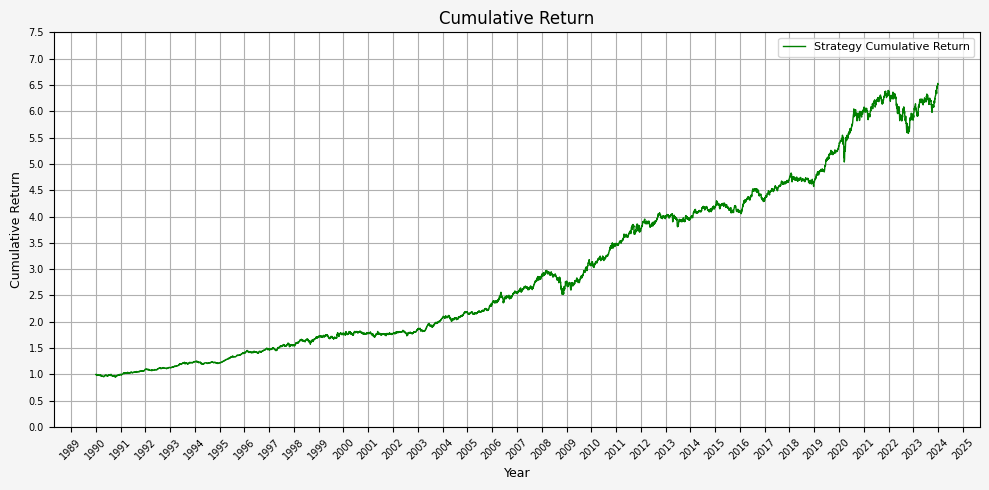

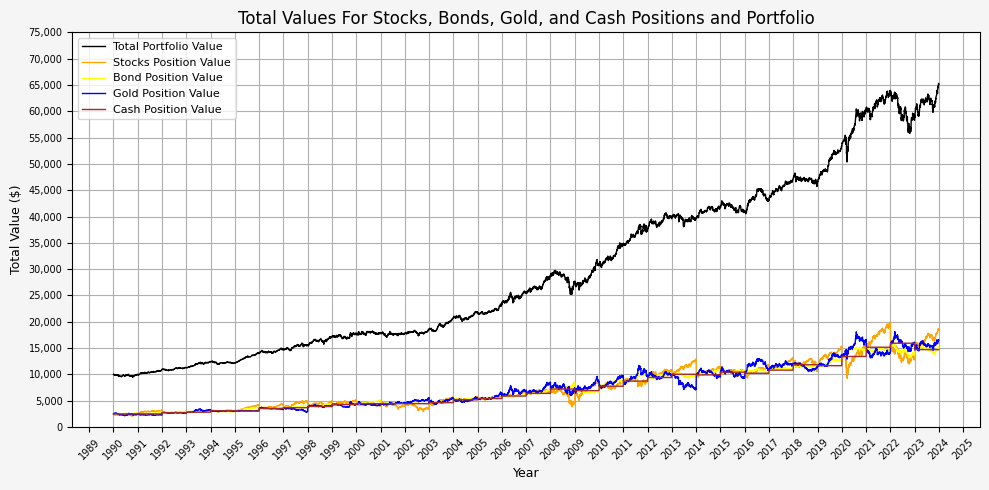

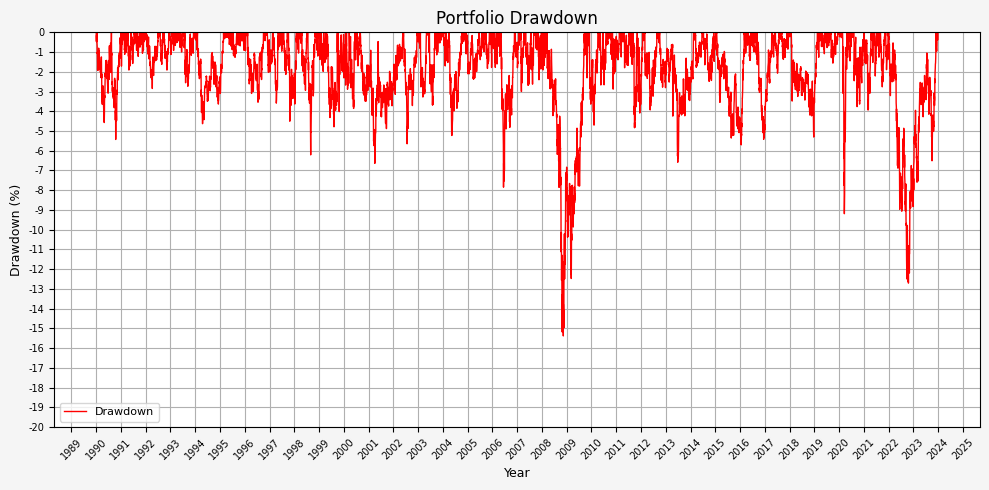

,Rebal_Month,Rebal_Day,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio,CAGR,Daily Max Return,Daily Max Return (Date),Daily Min Return,Daily Min Return (Date),Max Drawdown,Peak,Bottom,Recovery Date
0,NaN,NaN,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06


Strategy complete for Stocks_Bonds_Gold_Cash.
Summary stats complete for Stocks_Bonds_Gold_Cash.


,Rebal_Month,Rebal_Day,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio,CAGR,Daily Max Return,Daily Max Return (Date),Daily Min Return,Daily Min Return (Date),Max Drawdown,Peak,Bottom,Recovery Date
0,NaN,NaN,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
1,1,1,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06


Strategy complete for Stocks_Bonds_Gold_Cash.
Summary stats complete for Stocks_Bonds_Gold_Cash.


,Rebal_Month,Rebal_Day,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio,CAGR,Daily Max Return,Daily Max Return (Date),Daily Min Return,Daily Min Return (Date),Max Drawdown,Peak,Bottom,Recovery Date
0,NaN,NaN,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
1,1,1,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
2,1,2,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06


Strategy complete for Stocks_Bonds_Gold_Cash.
Summary stats complete for Stocks_Bonds_Gold_Cash.


,Rebal_Month,Rebal_Day,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio,CAGR,Daily Max Return,Daily Max Return (Date),Daily Min Return,Daily Min Return (Date),Max Drawdown,Peak,Bottom,Recovery Date
0,NaN,NaN,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
1,1,1,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
2,1,2,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
3,1,3,0.083,0.072,1.155,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-09-22


Strategy complete for Stocks_Bonds_Gold_Cash.
Summary stats complete for Stocks_Bonds_Gold_Cash.


,Rebal_Month,Rebal_Day,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio,CAGR,Daily Max Return,Daily Max Return (Date),Daily Min Return,Daily Min Return (Date),Max Drawdown,Peak,Bottom,Recovery Date
0,NaN,NaN,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
1,1,1,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
2,1,2,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
3,1,3,0.083,0.072,1.155,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-09-22
4,1,4,0.083,0.072,1.147,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-10-06


Strategy complete for Stocks_Bonds_Gold_Cash.
Summary stats complete for Stocks_Bonds_Gold_Cash.


,Rebal_Month,Rebal_Day,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio,CAGR,Daily Max Return,Daily Max Return (Date),Daily Min Return,Daily Min Return (Date),Max Drawdown,Peak,Bottom,Recovery Date
0,NaN,NaN,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
1,1,1,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
2,1,2,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
3,1,3,0.083,0.072,1.155,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-09-22
4,1,4,0.083,0.072,1.147,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-10-06
5,1,5,0.083,0.072,1.146,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-10-06


Strategy complete for Stocks_Bonds_Gold_Cash.
Summary stats complete for Stocks_Bonds_Gold_Cash.


,Rebal_Month,Rebal_Day,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio,CAGR,Daily Max Return,Daily Max Return (Date),Daily Min Return,Daily Min Return (Date),Max Drawdown,Peak,Bottom,Recovery Date
0,NaN,NaN,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
1,1,1,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
2,1,2,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
3,1,3,0.083,0.072,1.155,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-09-22
4,1,4,0.083,0.072,1.147,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-10-06
5,1,5,0.083,0.072,1.146,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-10-06
6,1,6,0.083,0.072,1.146,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-10-06


Strategy complete for Stocks_Bonds_Gold_Cash.
Summary stats complete for Stocks_Bonds_Gold_Cash.


,Rebal_Month,Rebal_Day,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio,CAGR,Daily Max Return,Daily Max Return (Date),Daily Min Return,Daily Min Return (Date),Max Drawdown,Peak,Bottom,Recovery Date
0,NaN,NaN,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
1,1,1,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
2,1,2,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
3,1,3,0.083,0.072,1.155,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-09-22
4,1,4,0.083,0.072,1.147,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-10-06
5,1,5,0.083,0.072,1.146,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-10-06
6,1,6,0.083,0.072,1.146,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-10-06
7,1,7,0.083,0.072,1.149,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-09-16


Strategy complete for Stocks_Bonds_Gold_Cash.
Summary stats complete for Stocks_Bonds_Gold_Cash.


,Rebal_Month,Rebal_Day,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio,CAGR,Daily Max Return,Daily Max Return (Date),Daily Min Return,Daily Min Return (Date),Max Drawdown,Peak,Bottom,Recovery Date
0,NaN,NaN,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
1,1,1,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
2,1,2,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
3,1,3,0.083,0.072,1.155,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-09-22
4,1,4,0.083,0.072,1.147,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-10-06
5,1,5,0.083,0.072,1.146,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-10-06
6,1,6,0.083,0.072,1.146,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-10-06
7,1,7,0.083,0.072,1.149,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-09-16
8,1,8,0.083,0.072,1.151,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-09-22


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7b126304a9c0>>
Traceback (most recent call last):
  File "/home/jared/python-virtual-envs/general/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Strategy complete for Stocks_Bonds_Gold_Cash.
Summary stats complete for Stocks_Bonds_Gold_Cash.


,Rebal_Month,Rebal_Day,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio,CAGR,Daily Max Return,Daily Max Return (Date),Daily Min Return,Daily Min Return (Date),Max Drawdown,Peak,Bottom,Recovery Date
0,NaN,NaN,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
1,1,1,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
2,1,2,0.083,0.072,1.152,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-10-06
3,1,3,0.083,0.072,1.155,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.154,2008-03-18,2008-11-12,2009-09-22
4,1,4,0.083,0.072,1.147,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-10-06
5,1,5,0.083,0.072,1.146,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-10-06
6,1,6,0.083,0.072,1.146,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-10-06
7,1,7,0.083,0.072,1.149,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-09-16
8,1,8,0.083,0.072,1.151,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-09-22
9,1,9,0.083,0.072,1.151,0.084,0.029,2020-03-24,-0.030,2020-03-12,-0.155,2008-03-18,2008-11-12,2009-09-16


In [ ]:
# List of funds to be used
fund_list = ['Stocks', 'Bonds', 'Gold', 'Cash']

# Starting cash contribution
starting_cash = 10000

# Monthly cash contribution
cash_contrib = 0

strat = strategy(fund_list, starting_cash, cash_contrib, perm_port, 1, 1).set_index('Date')
sum_stats = summary_stats(fund_list, strat[['Return']], 'Daily')
display(sum_stats)
plot_cumulative_return(strat)
plot_values(strat)
plot_drawdown(strat)

months = list(range(1, 13))
days = list(range(1, 28))

stats = pd.DataFrame(columns = ['Rebal_Month', 'Rebal_Day', 'Annualized Mean', 'Annualized Volatility', 'Annualized Sharpe Ratio', 'CAGR', 
                                'Daily Max Return', 'Daily Max Return (Date)', 'Daily Min Return', 'Daily Min Return (Date)', 'Max Drawdown', 
                                'Peak', 'Bottom', 'Recovery Date'])

for month in months:
    for day in days:
        strat = strategy(fund_list, starting_cash, cash_contrib, perm_port, month, day).set_index('Date')
        sum_stats = summary_stats(fund_list, strat[['Return']], 'Daily')
        stats = pd.concat([stats, sum_stats], ignore_index=True)
        stats.loc[stats.index[-1], 'Rebal_Month'] = month
        stats.loc[stats.index[-1], 'Rebal_Day'] = day
        display(stats)

plan_name = '_'.join(fund_list)
file = plan_name + "_All_Summary_Stats.xlsx"
location = file
stats.to_excel(location, sheet_name='data')
print(f"All summary stats complete for {plan_name}.")